In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [2]:
def resumen(datos):
    return print('Forma:\n', datos.shape,'\n\n',
                 'Columnas:\n', datos.columns,'\n\n',
                 'Tipos:\n', datos.dtypes,'\n\n',
                 'Datos nulos:\n', datos.isnull().sum(),'\n\n',
                 'Cabecera:\n', datos.head(10),'\n\n',
                 'Últimos datos:\n', datos.tail(10),'\n\n',
                 'Estadísticos:\n', datos.describe([0.05,0.25,0.5,0.75,0.95])
                )
def truncar(numero, decimales = 0):
    return np.trunc(numero*10**decimales)/(10**decimales)

In [97]:
def lineal(x, a, b):
    linea = a*x + b
    return linea

def spielman(t_rg, alfa, beta, ref, e0, t0):
    # Poner t y tref en centigrados
    #t0 = 227.1
    #t0 = 267
    #e0 = 409
    #e0 = 49.5
    tref = 10
    t = t_rg[:,0]
    rg = t_rg[:,1]
    nee = (-(alfa*beta*rg) / (alfa*rg + beta)
           + ref * np.exp(
               e0/(tref+273.16-t0)
               - e0/(t+273.16-t0)
            )
           )
    return nee
def sp_q10(t_rg, alfa, beta, ref, Q10):
    # Poner t y tref en centigrados
    tref = 10
    t = t_rg[:,0]
    rg = t_rg[:,1]
    nee = (-(alfa*beta*rg) / (alfa*rg + beta)
           + ref * Q10**((t-tref)/10)
           )
    return nee

In [77]:
def coef_determinacion(observaciones, predicciones):
    residuo = observaciones - predicciones
    ss_res = np.sum(residuo**2)
    ss_tot = np.sum((observaciones - np.mean(observaciones))**2)
    r_cuadrado = 1 - (ss_res/ss_tot)
    return r_cuadrado
def regresion(modelo, x, y, inicial = [1,1], pesos = None):
    # No puede haber nungún NaN
    ajuste, covarianzas = curve_fit(f = modelo,
                                    xdata = x,
                                    ydata = y,
                                    #sigma = pesos,
                                    p0 = inicial
                                   )
    predicciones = modelo(x, *ajuste)
    errores = np.sqrt(np.diag(covarianzas))
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    return predicciones, ajuste, errores, r_cuadrado, residuo

In [5]:
def metadata(ejex, ejey):
    # plt.title(titulo, fontsize = 60, fontweight='bold')
    plt.xlabel(ejex, fontsize = 35)
    plt.ylabel(ejey, fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return
def cifras_signif(i, cifras):
    texto = str('{:g}'.format(float('{:.{p}g}'.format(i, p = cifras))))
    return texto
def grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuad, nombres,
                   j = 3
                  ):
    etiqueta = ''
    iterador = list(range(len(nombres)))
    for i in iterador:
        valor = cifras_signif(ajuste[i], j)
        error = cifras_signif(errores[i], j)
        etiqueta = (etiqueta
                    + ' ' + nombres[i] + ' = ' + valor
                    + '; std ' + nombres[i] + ' = ' + error
                    + '\n')
    etiqueta = etiqueta + ' $R^2$ = ' + cifras_signif(r_cuad, j)
    plt.plot(x, y, 'bo', markersize = 2)
    plt.plot(x, predicciones, 'r-',
             label = etiqueta
             )
    plt.legend(fontsize = 20)
    return

In [6]:
def validar(metodo, ajuste, validacion_x, validacion_y, lab, nombres):
    pred = metodo(validacion_x.values,
                  *ajuste
                  )
    recta, var, errores, r_cuadrado, res = regresion(lineal,
                                                     validacion_y,
                                                     pred
                                                     )
    plt.figure(figsize = (18, 9))
    grafico_modelo(validacion_y, pred, recta,
                   var, errores, r_cuadrado,
                   nombres
                  )
    metadata(lab + ' Obs', lab + ' Pred')
    extremos = [validacion_y.min(), validacion_y.max()]
    plt.plot(extremos, extremos, 'g--')
    return pred, r_cuadrado, var, errores

In [7]:
datos = pd.read_csv(
    #'C:\\Users\\nahue\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    delimiter = '\t',
    decimal = '.',
    na_values = -9999,
    skiprows = [1],
    encoding = 'ascii'
    )

In [8]:
resumen(datos)

Forma:
 (14956, 38) 

 Columnas:
 Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar', 'TS1', 'TS2', 'TS3', 'TS4', 'U', 'DIR', 'PP', 'QG1',
       'QG2', 'WET', 'PAR', 'TSH1', 'HS1', 'GH1', 'TSH2', 'HS2', 'GH2', 'TSH3',
       'HS3', 'GH3', 'TSH4', 'HS4', 'GH4', 'PAR.1', '   r_err_co2[%]',
       '   noise_co2[%]'],
      dtype='object') 

 Tipos:
 Year               float64
DoY                float64
Hour               float64
NEE                float64
LE                 float64
H                  float64
Rg                 float64
Tair               float64
Tsoil              float64
rH                 float64
VPD                float64
Ustar              float64
TS1                float64
TS2                float64
TS3                float64
TS4                float64
U                  float64
DIR                float64
PP                 float64
QG1                float64
QG2                float64
WET                float64
PAR     

In [9]:
datos['Error porcent'] = datos['   r_err_co2[%]'] + datos['   noise_co2[%]']
datos['Error'] = abs(datos['Error porcent']/100 * datos['NEE'])

In [10]:
datos_diurnos = datos[(datos['Rg'] >= 5)
                      & (datos['Ustar'] > 0.14167)
                      & (datos['PAR.1'] > 1)
                      & pd.notna(datos['NEE'])
                      & (datos['Error porcent'] < 30)
                      #& (datos['Error'] < 0.5)
                     ]
datos_diurnos.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,HS3,GH3,TSH4,HS4,GH4,PAR.1,r_err_co2[%],noise_co2[%],Error porcent,Error
count,3428.0,3428.000000,3428.000000,3428.000000,3399.000000,3402.000000,3428.000000,3428.000000,3428.000000,3428.000000,...,3138.000000,3138.000000,3233.000000,3233.000000,3233.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000
mean,2018.0,266.954492,13.103121,-3.418176,116.730619,125.694120,441.700308,15.795051,12.973970,62.177897,...,0.534242,0.212203,12.704182,0.399682,0.296581,819.217154,11.659976,0.938211,12.598187,0.427237
std,0.0,61.333363,3.307610,3.356549,88.427451,119.771604,298.375613,5.449616,4.219740,15.736072,...,0.031814,0.025817,3.036121,0.040408,0.037152,534.261431,3.713431,0.762902,3.978988,0.337967
min,2018.0,91.000000,0.125000,-21.042500,-187.969055,-86.813431,5.005000,-0.645000,2.772500,19.600000,...,0.444500,0.148000,7.200000,0.200000,0.167500,1.030000,5.981359,0.084813,7.034158,0.000247
1%,2018.0,95.000000,6.125000,-14.870246,-11.942811,-49.606118,7.889850,4.795500,4.484725,27.506050,...,0.454185,0.167000,7.400000,0.235000,0.172000,15.342550,7.132718,0.203161,8.059399,0.012354
10%,2018.0,174.000000,8.625000,-7.471940,19.287605,-13.223467,62.503500,9.547000,7.370000,41.129500,...,0.469350,0.175000,8.881000,0.347500,0.244000,117.170000,8.250884,0.399037,9.158013,0.096049
25%,2018.0,229.000000,10.625000,-5.061863,51.025356,28.835639,196.162500,11.767500,9.356875,51.406250,...,0.539500,0.194000,10.055000,0.378500,0.277500,373.937500,9.224265,0.577823,10.033732,0.184579
50%,2018.0,277.000000,13.125000,-2.854175,97.094013,102.024967,401.051136,15.237500,12.942500,62.750000,...,0.546000,0.212000,12.400000,0.406500,0.308000,770.475000,10.658099,0.783681,11.392244,0.349516
75%,2018.0,318.000000,15.625000,-1.306263,166.777548,207.065050,657.150000,19.041250,16.278750,73.805000,...,0.551000,0.229000,15.395000,0.426500,0.319500,1222.500000,12.801223,1.005035,13.648502,0.574139
90%,2018.0,340.000000,17.625000,0.165320,243.819806,297.734886,898.500000,23.395000,18.609000,83.200000,...,0.558000,0.249500,16.800000,0.445000,0.339000,1608.800000,16.497556,1.458121,17.664688,0.839963


In [12]:
muestra = datos_diurnos.sample(frac = 4/5, random_state = 1)
validacion = datos_diurnos.drop(muestra.index)

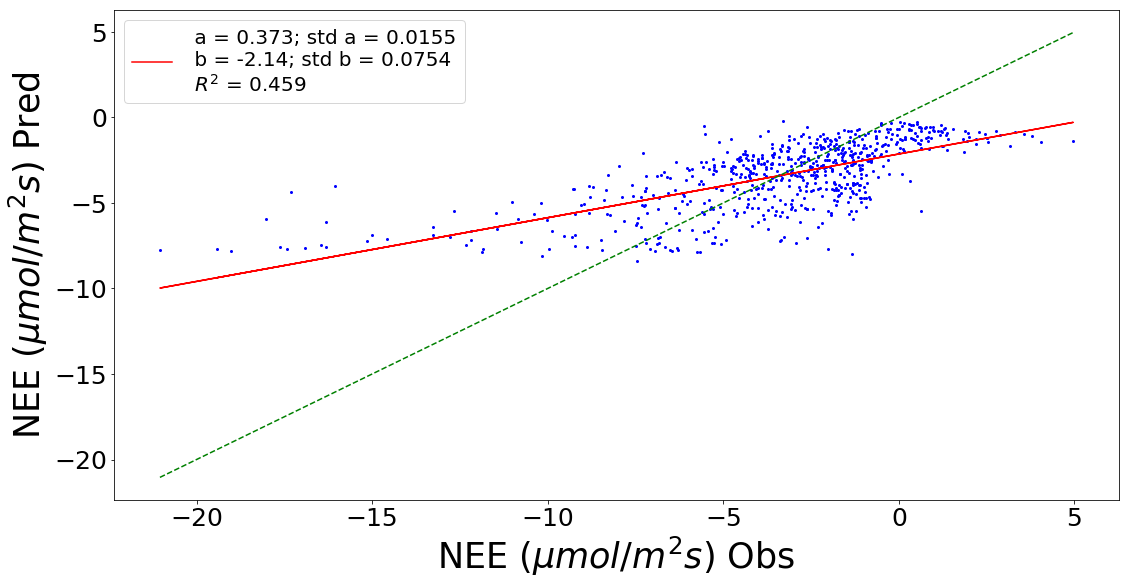

In [48]:
t_rg = muestra[['Tsoil', 'PAR.1']].values
nee = muestra['NEE'].values
reg = regresion(spielman,
                t_rg,
                nee,
                inicial = [0.01,
                           6,
                           1,
                          ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg
val_x = validacion[['Tsoil', 'PAR.1']]
val_y = validacion['NEE']
val_final = validar(spielman, ajuste, val_x,
                    val_y, 'NEE ($\\mu mol/m^2 s$)',
                    ['a', 'b']
                   )
#plt.savefig('C:\\Users\\nahue\\Desktop\\Tesis_2\\Escritura\\Spielmann.png')
#plt.savefig('C:\\Users\\BIOMET\\Desktop\Tesis_2\\Spielmann\\Spielmann.png')

In [49]:
ajuste

array([ 3.48898173e-03,  1.27899305e+03, -3.87298520e-01])

In [50]:
r_cuadrado

0.42766083186444426

C:\Users\BIOMET\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


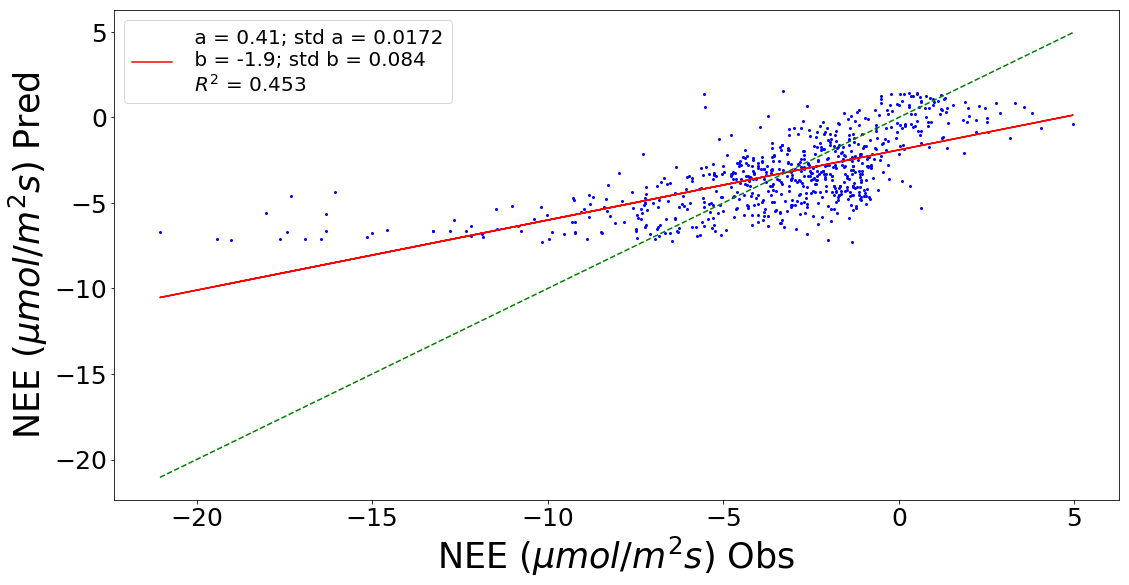

In [53]:
t_rg = muestra[['Tsoil', 'PAR.1']].values
nee = muestra['NEE'].values
reg = regresion(spielman,
                t_rg,
                nee,
                inicial = [0.01,
                           6,
                           1,
                           50,
                           250
                          ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg
val_x = validacion[['Tsoil', 'PAR.1']]
val_y = validacion['NEE']
val_final = validar(spielman, ajuste, val_x,
                    val_y, 'NEE ($\\mu mol/m^2 s$)',
                    ['a', 'b']
                   )
#plt.savefig('C:\\Users\\nahue\\Desktop\\Tesis_2\\Escritura\\Spielmann.png')
#plt.savefig('C:\\Users\\BIOMET\\Desktop\Tesis_2\\Spielmann\\Spielmann.png')

In [54]:
ajuste

array([ 1.18392238e-02,  1.07427210e+01,  1.52928219e+00, -8.40218733e+00,
        2.95765030e+02])

In [55]:
r_cuadrado

0.4419318251359463

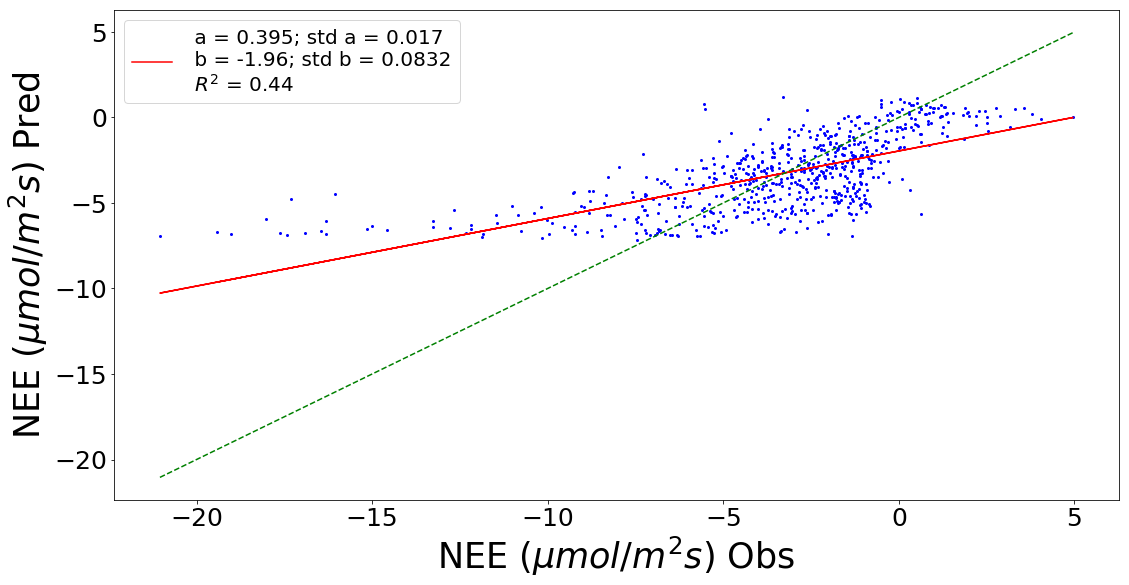

In [61]:
t_rg = muestra[['Tsoil', 'PAR.1']].values
nee = muestra['NEE'].values
reg = regresion(spielman,
                t_rg,
                nee,
                inicial = [0.01,
                           6,
                           1,
                           50,
                           #250
                          ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg
val_x = validacion[['Tsoil', 'PAR.1']]
val_y = validacion['NEE']
val_final = validar(spielman, ajuste, val_x,
                    val_y, 'NEE ($\\mu mol/m^2 s$)',
                    ['a', 'b']
                   )
#plt.savefig('C:\\Users\\nahue\\Desktop\\Tesis_2\\Escritura\\Spielmann.png')
#plt.savefig('C:\\Users\\BIOMET\\Desktop\Tesis_2\\Spielmann\\Spielmann.png')

In [62]:
ajuste

array([ 8.63533701e-03,  1.35639649e+01,  8.93609881e-01, -2.18946792e+01])

In [63]:
r_cuadrado

0.42154872981123015

C:\Users\BIOMET\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in power


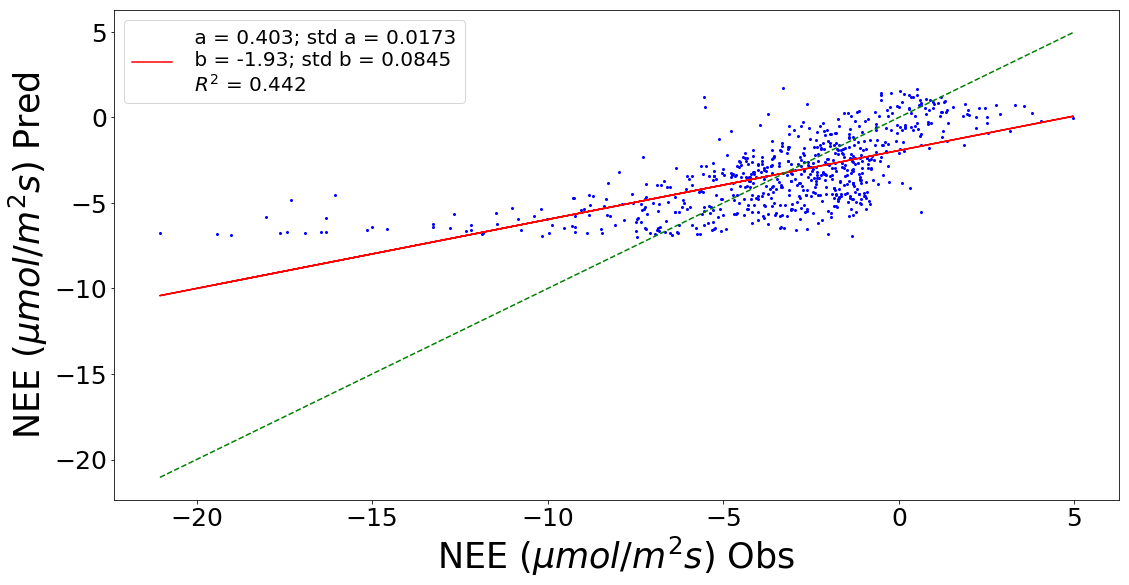

In [99]:
t_rg = muestra[['Tsoil', 'PAR.1']].values
nee = muestra['NEE'].values
reg = regresion(sp_q10,
                t_rg,
                nee,
                inicial = [0.01,
                           6,
                           1,
                           5
                          ],
                pesos = None
                )
predicciones, ajuste, errores, r_cuadrado, residuo = reg
val_x = validacion[['Tsoil', 'PAR.1']]
val_y = validacion['NEE']
val_final = validar(sp_q10, ajuste, val_x,
                    val_y, 'NEE ($\\mu mol/m^2 s$)',
                    ['a', 'b']
                   )
#plt.savefig('C:\\Users\\nahue\\Desktop\\Tesis_2\\Escritura\\Spielmann.png')
#plt.savefig('C:\\Users\\BIOMET\\Desktop\Tesis_2\\Spielmann\\Spielmann.png')

In [100]:
ajuste

array([ 0.01144241, 11.23846781,  1.3950522 ,  0.40636103])

In [101]:
r_cuadrado

0.4292760586307969

In [103]:
(1.14-1.40)/1.14*100

-22.80701754385965

In [104]:
nocturna_bim = [2.50, 1.08, 1.09, 1.24, 1.45]

C:\Users\BIOMET\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in power


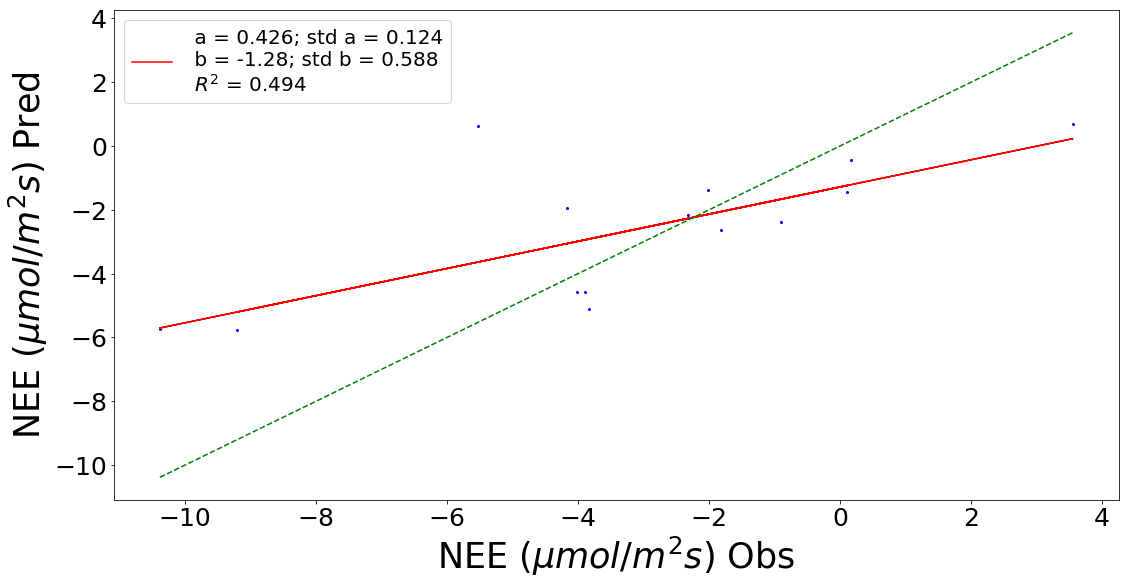

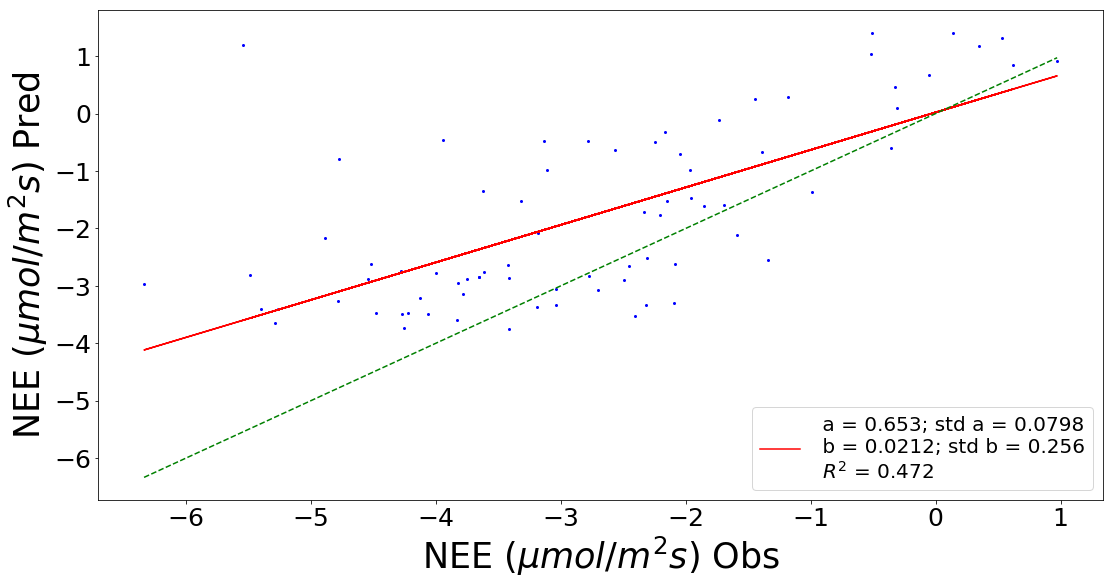

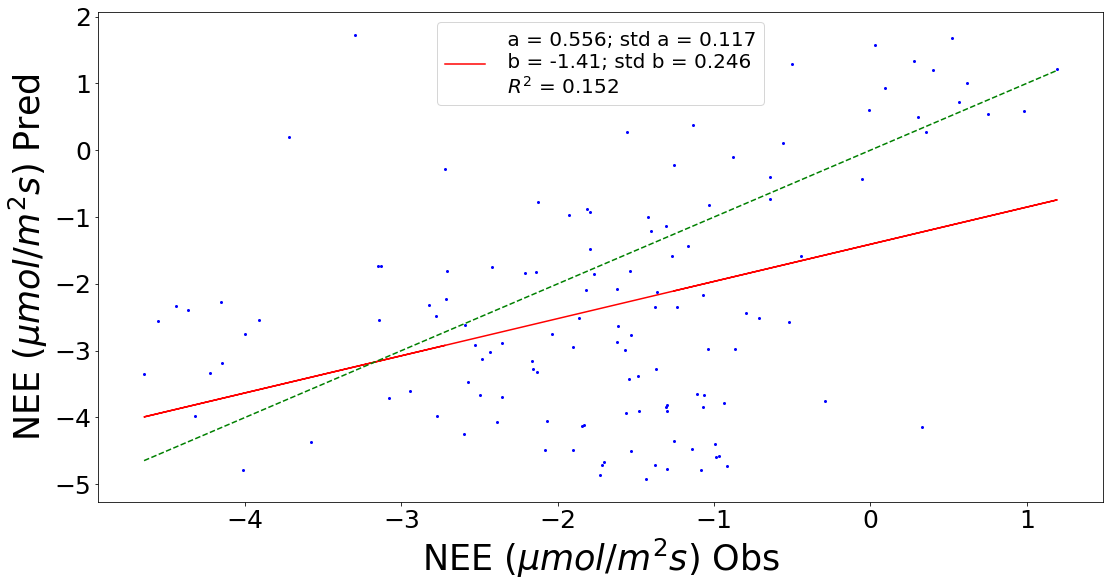

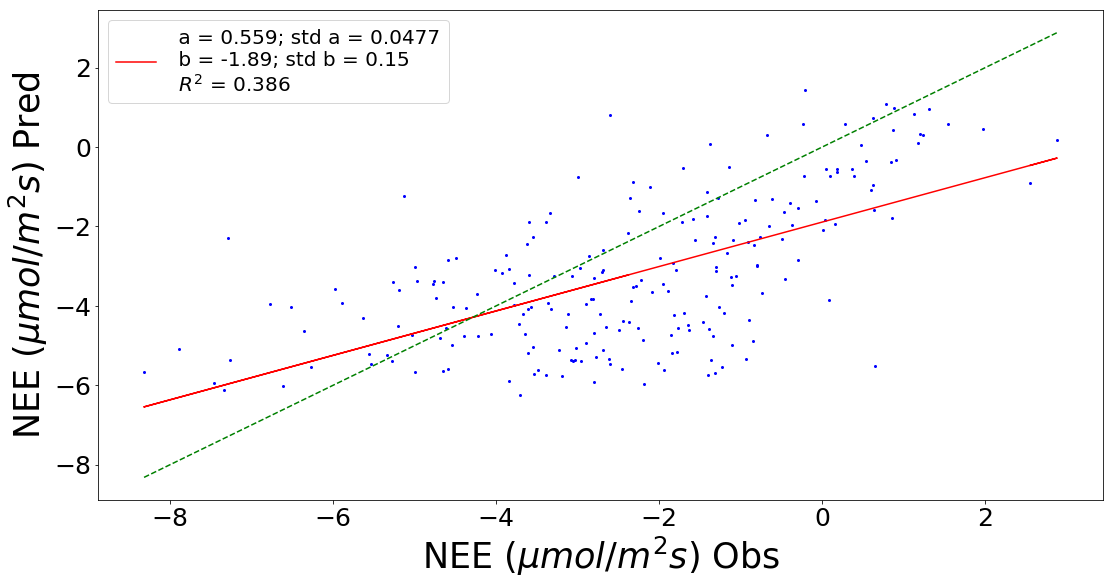

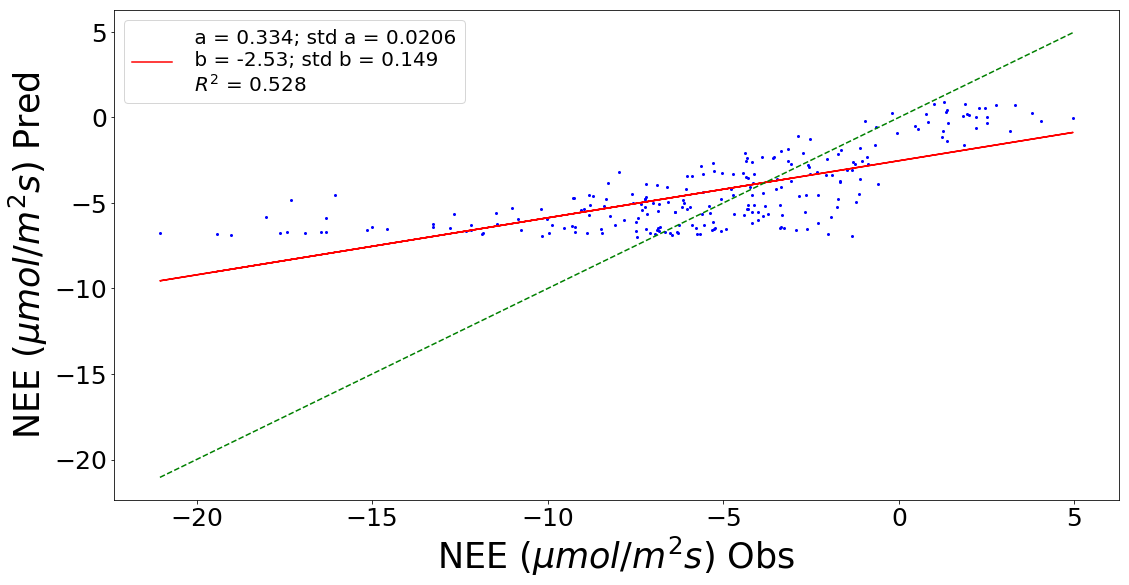

In [125]:
dias = np.arange(60, 420, 60)
ajustes = list(range(1, len(dias)))
r_cuadr = list(range(1, len(dias)))
resp = list(range(1, len(dias)))
diff = list(range(len(resp)))
for i in list(range(1, len(dias))):
    desde = dias[i-1]
    hasta = dias[i]
    muestra_vent = muestra[(muestra['DoY'] > desde)
                           & (muestra['DoY'] < hasta)
                           ]
    validacion_vent = validacion[(validacion['DoY'] > desde)
                                 & (validacion['DoY'] < hasta)
                                 ]
    t_rg = muestra_vent[['Tsoil', 'PAR.1']].values
    nee = muestra_vent['NEE'].values
    reg = regresion(sp_q10,
                    t_rg,
                    nee,
                    inicial = [0.01,
                               6,
                               1,
                               5
                              ],
                    pesos = None
                    )
    predicciones, ajustes[i-1], errores, r_cuadr[i-1], residuo = reg
    val_x = validacion_vent[['Tsoil', 'PAR.1']]
    val_y = validacion_vent['NEE']
    val_final = validar(sp_q10, ajuste, val_x,
                        val_y, 'NEE ($\\mu mol/m^2 s$)',
                        ['a', 'b']
                       )
    resp[i-1] = ajustes[i-1][2]
    diff[i-1] = 100*(nocturna_bim[i-1]-resp[i-1]) / nocturna_bim[i-1]

In [126]:
r_cuadr

[0.3401005235002805,
 0.5038984131988282,
 0.28272229371569213,
 0.4192771530198678,
 0.538179814132806]

In [127]:
ajustes

[array([ 0.01030208,  9.86462021, -0.24782894,  6.28736908]),
 array([0.03487233, 6.13423237, 1.04625657, 0.53156343]),
 array([0.08930696, 4.66563985, 2.38429154, 1.50884005]),
 array([0.02036912, 7.24888805, 1.81466974, 1.28177826]),
 array([ 0.01913649, 16.06934917,  1.67942527,  1.8843854 ])]

In [128]:
resp

[-0.24782893908017478,
 1.0462565672195003,
 2.3842915385829304,
 1.8146697371496898,
 1.6794252746434926]

In [129]:
diff

[109.91315756320698,
 3.1243919241203457,
 -118.74234298925965,
 -46.34433364110402,
 -15.822432734033974]

In [130]:
nocturna_bim

[2.5, 1.08, 1.09, 1.24, 1.45]

In [133]:
100*(2.5--0.24)/2.5

109.6